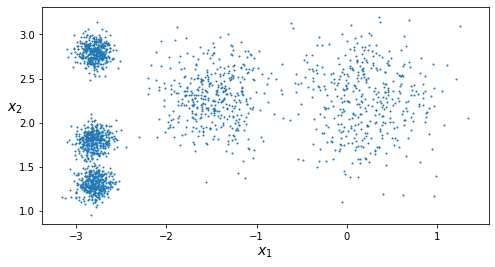

In [1]:
#Chapter 9 is all about unsupervised learning
#Start with clustering. DBSCAN and k means

#Use make blobs to create some data

import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [2]:
#Use kmeans with 5 cluster centers to fit the data

from sklearn.cluster import KMeans

k=5

kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [3]:
#can see the centroids of each cluster

kmeans.cluster_centers_

array([[-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999]])

In [4]:
#can retrieve a voronoi tesselation using these centroids to see the decision boundaries

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

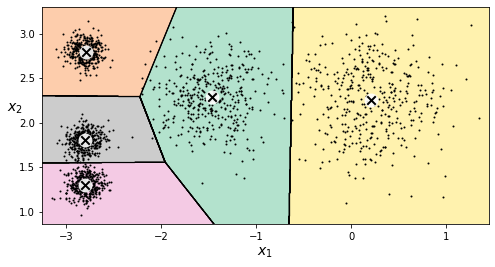

In [5]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [6]:
#It can happen that the decision boundaries will converge to a local optimum.
#This is when they are randomly initialized
#take a look at some initialization methods for the centroids.

#set the init manually

good_init = np.array([[-3,3], [-3,2], [-3,1], [-1,2], [0,2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)

y_pred = kmeans.fit_predict(X)

In [7]:
#performance measure of the clusters is called the inertia

kmeans.inertia_

211.5985372581684

In [8]:
#using mini batch Kmeans haas the potential to speed up the algorithm greatly.

from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [9]:
#the right number of clusters is not always obvious

#we can use the silhouette score to decide

from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

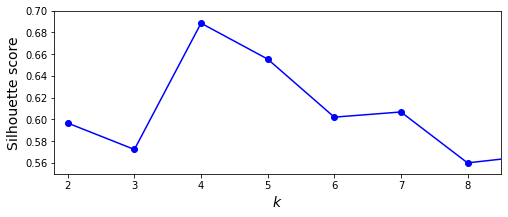

In [10]:
#plot the silhouette scores for different k's

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]

inertias = [model.inertia_ for model in kmeans_per_k]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

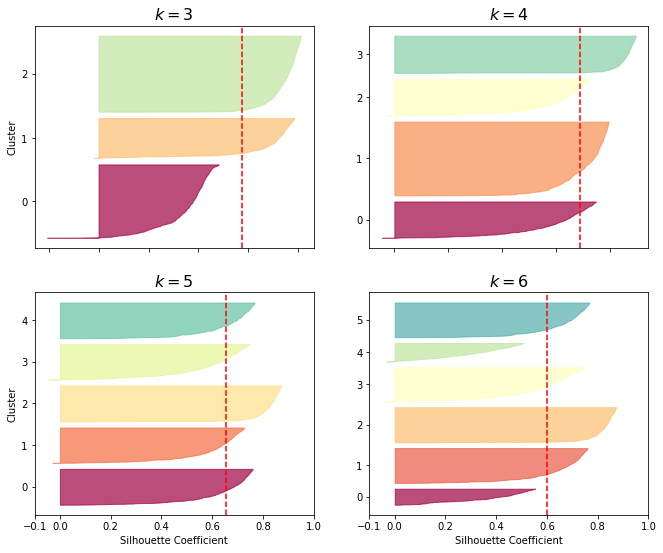

In [11]:
#silhouette diagrams are useful to further analyse the silhouette scores

import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [14]:
#clustering can be used when processing images
#for example clustering pixels into the different color groups

#load an image
#
import os
from matplotlib.image import imread

image = imread(os.path.join(r'C:\Users\Rudy Schneeweiss\Pictures\alex', '21040852_351829971921489_1412690124_n.jpg'))
image.shape

(467, 360, 3)

In [15]:
X = image.reshape(-1, 3)

kmeans = KMeans(n_clusters=10).fit(X)

segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
segmented_img = np.array(segmented_img,np.int32)


In [16]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_img = np.array(segmented_img,np.int32)
    segmented_imgs.append(segmented_img.reshape(image.shape))

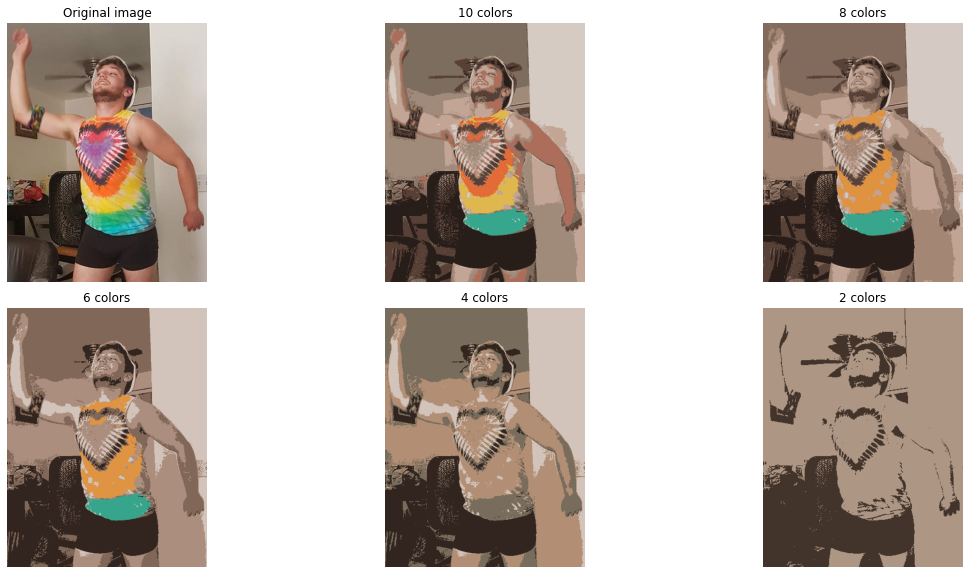

In [17]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

In [18]:
#Warhol-esque!

#we can use clustering for preprocessing.
#lets load MNIST data set - digits and try using clustering for dimensionality reduction

from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [21]:
log_reg.score(X_test, y_test)

0.9644444444444444

In [22]:
#try to beat this score by applying kmeans during preprocessing

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)),
    ('log_reg', LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [23]:
pipeline.score(X_test, y_test)

0.9666666666666667

In [24]:
#this was a significaant improvement with an arbitrary number for k
#performing aa gridseaarch should improve even further

from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(40,60))

grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..............................kmeans__n_clusters=40; total time=   3.2s
[CV] END ..............................kmeans__n_clusters=40; total time=   3.3s
[CV] END ..............................kmeans__n_clusters=40; total time=   3.2s
[CV] END ..............................kmeans__n_clusters=41; total time=   3.1s
[CV] END ..............................kmeans__n_clusters=41; total time=   3.0s
[CV] END ..............................kmeans__n_clusters=41; total time=   3.6s
[CV] END ..............................kmeans__n_clusters=42; total time=   2.9s
[CV] END ..............................kmeans__n_clusters=42; total time=   3.2s
[CV] END ..............................kmeans__n_clusters=42; total time=   3.5s
[CV] END ..............................kmeans__n_clusters=43; total time=   3.4s
[CV] END ..............................kmeans__n_clusters=43; total time=   3.3s
[CV] END ..............................kmeans__n

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(40, 60)}, verbose=2)

In [25]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

In [26]:
grid_clf.score(X_test, y_test)

0.9688888888888889

In [42]:
#Another use case is with semi supervised learning

#train an LR on 50 instnces of the labeled digits data

n_labeled = 50

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs",max_iter=5000, random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [43]:
log_reg.score(X_test, y_test)

0.8511111111111112

In [44]:
#accuracy is much lower. Expected because we've only used 50 instances to train

#cluster the training set into 50 clusters, then find the image closest to the centroid of each the 50 clusters
#these will be our representative images

k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

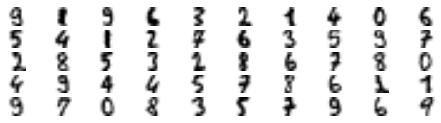

In [45]:
#plot each of these images now and label them manually

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [46]:
y_train[representative_digit_idx]

array([9, 1, 9, 6, 3, 2, 1, 4, 0, 6, 5, 4, 1, 2, 7, 6, 3, 5, 9, 7, 2, 8,
       5, 3, 2, 8, 6, 7, 8, 0, 4, 9, 4, 4, 5, 7, 8, 6, 1, 1, 9, 7, 0, 8,
       3, 5, 7, 9, 6, 9])

In [47]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 2, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

In [48]:
#now try again with our LR, but this time, we have a representative image from each cluster

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.07333333333333333

In [49]:
##WHY IS THIS GOING DOWN?

In [50]:
#Next we will look at DBSCAN
#DBSCAN defines clusters s continuous regions of high density

#counts neighbors of an instnce within a distance epsilon

#works well if clusters are well seperated by low density regions, and if they re dense enough themselves

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [51]:
#labels of aall instances can be found s fol;lows. -1 indicates they are considered anomalies

dbscan.labels_

array([ 0,  0,  0,  1,  6,  1,  4,  0,  2,  1,  1,  9, -1,  7,  3,  3,  4,
        1,  0, -1,  5,  6,  1,  2,  3,  1,  4,  7,  6,  0,  8,  3,  2,  1,
        0,  2,  7,  1,  3,  0,  6,  0,  9,  0,  3,  3,  2,  3,  9,  4,  3,
        1,  9,  1,  3,  3, 10,  0,  3,  1,  0,  3,  0,  0,  4,  4,  3,  2,
        2,  0,  1,  0,  9,  5,  1,  4,  7,  3,  0,  3,  3,  1,  3, -1, -1,
        3,  8,  0,  0,  3,  2,  1,  6,  1,  0,  3,  0,  0,  4,  2,  4,  3,
        0,  3,  1,  3,  8,  7,  2, 10,  3,  3,  7,  3,  0,  3,  3,  1,  9,
        8,  0,  0,  2,  0,  1,  0,  3,  0,  4,  0,  4,  6,  0,  1,  7,  2,
        1, -1,  1,  3,  2,  1,  0,  3,  7,  1,  3,  4,  3,  3,  3,  7,  2,
        3,  2,  1,  1,  0,  6,  1,  0,  7,  2, -1,  2,  5,  7,  1, -1,  1,
        0, -1,  0,  5, 11,  4,  9,  2,  3, -1, 10,  1, -1,  7, -1,  7,  3,
        4,  6,  5,  5,  3,  0,  1, -1,  2,  3,  1,  1,  3,  3,  3,  3,  3,
        2,  0,  7,  4,  3,  9,  4,  4,  3,  7, -1,  0,  7, 10,  4,  7,  6,
        4,  3,  0,  3, -1

In [52]:
len(dbscan.core_sample_indices_)

814

In [53]:
dbscan.components_

array([[ 0.34819071,  0.94560043],
       [ 0.25897855,  1.01392941],
       [ 0.91039249,  0.46351476],
       ...,
       [ 1.9053753 ,  0.46469749],
       [ 0.32411275,  0.9803431 ],
       [ 1.86448477, -0.09049433]])

In [54]:
#visualize our clusters and try a different epsilon

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [55]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

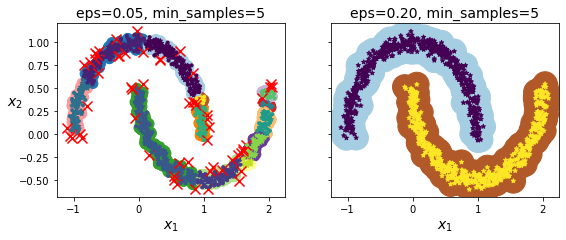

In [57]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [60]:
#can see that an epsilon of 0.2 provides a much better fit

#DBSCAN can't predict the label of a new value, we need to use other classifiers to do this.

#train kneighbors here

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [62]:
#put in a few data points and see what kneighbors says

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])

knn.predict(X_new)

array([0, 1, 0, 1], dtype=int64)

In [63]:
knn.predict_proba(X_new)

array([[0.84, 0.16],
       [0.  , 1.  ],
       [0.84, 0.16],
       [0.  , 1.  ]])

In [65]:
#to introduce a maximum distance, use the kneighbors() method instead of the kneighborsclassifier

y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)

y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]

y_pred[y_dist > 0.2] = -1

y_pred.ravel()

array([-1,  1,  0, -1], dtype=int64)

In [67]:
#If we can ssume tht the clusters were generated using aa gaussian distribution model, we can use GMM

from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [68]:
gm.weights_

array([0.58345851, 0.21680834, 0.19973315])

In [69]:
gm.means_

array([[ 0.47645071,  0.2684638 ],
       [ 1.71299376, -0.08379445],
       [-0.74990811,  0.55000011]])

In [70]:
gm.covariances_

array([[[ 0.16492129, -0.09752213],
        [-0.09752213,  0.28667447]],

       [[ 0.06633869,  0.07077654],
        [ 0.07077654,  0.0937474 ]],

       [[ 0.04700822,  0.05749444],
        [ 0.05749444,  0.08595645]]])

In [71]:
#we cn make sure the EM converged and check how maany iterations it took

gm.converged_

True

In [72]:
gm.n_iter_

18

In [73]:
gm.predict(X)

array([0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0, 1, 1, 1,
       2, 1, 0, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2,
       0, 1, 1, 0, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0,
       0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 1,
       0, 2, 0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0,
       0, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2,
       1, 1, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 0, 1, 0, 2,
       2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0,
       1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0,
       2, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 1, 0,

In [74]:
gm.predict_proba(X)

array([[1.00000000e+000, 1.05530978e-079, 5.22648595e-018],
       [1.00000000e+000, 1.82807420e-090, 7.53711818e-013],
       [1.00000000e+000, 1.55260264e-025, 7.09325661e-075],
       ...,
       [1.00000000e+000, 1.65373521e-083, 4.21160971e-016],
       [4.50384754e-001, 3.47987578e-138, 5.49615246e-001],
       [2.26596008e-003, 9.97734040e-001, 2.19285585e-236]])

In [75]:
#since GMM is a generative model, we can sample instances from it

X_new, y_new = gm.sample(6)

X_new

array([[-0.20557177,  0.17113982],
       [-0.1885117 ,  2.07755651],
       [ 0.93179564, -0.75422697],
       [ 0.9382099 , -0.37704252],
       [ 0.54795769,  0.10574895],
       [-0.27382986,  1.03939858]])

In [76]:
y_new

array([0, 0, 0, 0, 0, 2])

In [77]:
#can also estimate the density at any given location using score samples

gm.score_samples(X)

array([-1.57778229, -1.71271781, -1.75478702, -0.47834334, -0.97802682,
       -2.18944488, -0.87270623, -1.95552583, -1.26939246, -0.60702844,
       -1.8268349 , -0.23921598, -1.79884238, -1.35836885, -1.51994478,
       -1.46924034, -0.32164407, -0.50416419, -1.79655008, -0.29950638,
       -0.84733401, -0.49848098, -0.80150584, -0.58859838, -1.95578612,
       -0.96044884, -0.09806702, -1.55615048, -0.63738614, -1.56408333,
       -2.32545928, -1.72549854, -2.15217779, -0.44727168, -1.43301175,
       -0.70843416, -1.51019315, -1.93479446, -1.6892847 , -1.53513445,
       -0.6207573 , -1.44026088, -0.69006889, -1.97635598, -1.88908393,
       -1.8466346 , -0.71956685, -1.78403372, -0.08499785, -2.71300022,
       -1.7275658 , -1.91846517, -1.30188529, -2.15145025, -1.53920762,
       -1.30210109, -0.95840549, -1.85951174, -1.41885067,  0.10465441,
       -1.84270323, -1.44648684, -1.72237643, -1.52299781, -1.22157127,
       -0.18816944, -1.66215292, -1.15509264, -1.70648517, -1.73

In [78]:
#plot our GMM

from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

C:\Users\Rudy Schneeweiss\AppData\Local\Temp\ipykernel_9072\3044753949.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
C:\Users\Rudy Schneeweiss\AppData\Local\Temp\ipykernel_9072\3044753949.py:16: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


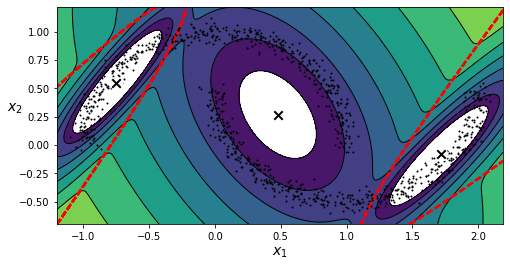

In [79]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

In [80]:
#interesting boundaries for 3 clusters on the make moons data

#obviously this is not the correct number of clusters, try again with 2

gm = GaussianMixture(n_components=2, n_init=10)
gm.fit(X)

GaussianMixture(n_components=2, n_init=10)

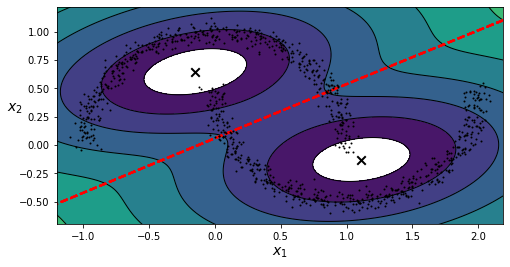

In [81]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

In [82]:
#still not correct. the gmm seems to be aan inaappropriaate method of clustering this particular data.

#this is to be expected, becaause it is not a Gaussian distribution!

#we can use Gaussian mixtures for anomly detection

densities = gm.score_samples(X)

density_threshold = np.percentile(densities, 4)

anomalies = X[densities < density_threshold]

In [84]:
#We can remove extreme utliers using this method and provide abetter fit.

#sp how can we know whaat the ideal number of clusters is for gmm?

gm.bic(X)

3489.2628787652543

In [85]:
gm.aic(X)

3435.2775706964508

In [86]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [87]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

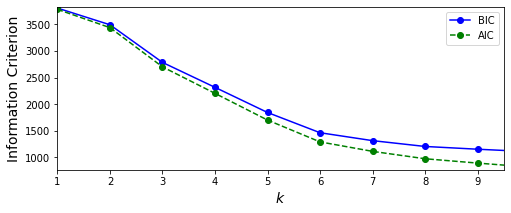

In [90]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])

plt.legend()

plt.show()

In [ ]:
#note that for a gaussian distribution, we would see the ideal number of clusters as the lowest point on this graph